In [1]:
import datetime
import configparser
import os

import numpy as np
import pandas as pd

In [2]:
MODEL_NAME='1SM'
MESH_NAME='finest'
DEGREE = 3
CONFIG_NAME = 'comb'
K = 9
ROMBERG_K = 5
GROUNDED_PLATE_AT = -0.088

FILENAME_PATTERN = f'FEM/solutions/paper/{MODEL_NAME}/{MESH_NAME}_{DEGREE}/{CONFIG_NAME}_sampled/{K}/{{name}}.npz'
ES_PREFIX = f'ES/paper_{MODEL_NAME}__{MESH_NAME}_{DEGREE}_{CONFIG_NAME}'

In [3]:
from _dicom import crude_plot_data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cbf

Tworzę elektrody

In [5]:
ELECTRODES = []
for col, x in zip('ABCDE', np.linspace(-6e-3, 6e-3, 5)):
    for row, z in enumerate(np.linspace(0.046, 0.076, 13)):
        ELECTRODES.append({'NAME': f'{col}_{row:02d}',
                           'X': x,
                           'Y': 0.0,
                           'Z': z})
ELECTRODES = pd.DataFrame(ELECTRODES)

In [14]:
class Electrode_kESI(object):
    def __init__(self, filename, decimals_tolerance=None, dx=0):
        self.name = filename[-8:-4]
        self.filename = filename
        self.decimals_tolerance = decimals_tolerance
        self.dx = dx
        with np.load(filename) as fh:
            self._X = self.round(fh['X'])
            self._Y = self.round(fh['Y'])
            self._Z = self.round(fh['Z'])
            self.x, self.y, self.z = fh['LOCATION']
#             try:
            self.base_conductivity = fh['BASE_CONDUCTIVITY']
#             except KeyError:
#                 pass
    
    def round(self, A):
        if self.decimals_tolerance is None:
            return A
        return np.round(A, decimals=self.decimals_tolerance)

    def correction_potential(self, X, Y, Z):
        _X, IDX_X, _ = np.intersect1d(self._X, self.round(X[:, 0, 0]), return_indices=True)
        assert len(_X) == np.shape(X)[0]
        _Y, IDX_Y, _ = np.intersect1d(self._Y, self.round(Y[0, :, 0]), return_indices=True)
        assert len(_Y) == np.shape(Y)[1]
        _Z, IDX_Z, _ = np.intersect1d(self._Z, self.round(Z[0, 0, :]), return_indices=True)
        assert len(_Z) == np.shape(Z)[2]

        with np.load(self.filename) as fh:
            return fh['CORRECTION_POTENTIAL'][np.ix_(IDX_X, IDX_Y, IDX_Z)]

    def base_potential(self, X, Y, Z):
        return (0.25 / (np.pi * self.base_conductivity)
                / (self.dx * 0.15
                   + np.sqrt(np.square(X - self.x)
                             + np.square(Y - self.y)
                             + np.square(Z - self.z))))

        
class Electrode_kCSD(object):
    def __init__(self, filename):
        self.name = filename[-8:-4]
        with np.load(filename) as fh:
            self.x, self.y, self.z = fh['LOCATION']

In [10]:
electrode = Electrode_kESI(FILENAME_PATTERN.format(name='A_00'))

XX = electrode._X
YY = electrode._Y
ZZ = electrode._Z

In [11]:
dx = (XX[-1] - XX[0]) / (len(XX) - 1)
SRC_R_MAX = (2**(ROMBERG_K - 1)) * dx
ROMBERG_N = 2**ROMBERG_K + 1
print(SRC_R_MAX)

NAIVE_R_MAX = 90e-3 - SRC_R_MAX
NAIVE_R_MIN = 31e-3

INFORMED_R_MAX = 79e-3
INFORMED_R_MIN = 67e-3

E_Z_MAX = 76.1e-3
E_Z_MIN = 39.9e-3
E_X_DIST_MAX = 6.0001e-3


X_DIST_MAX = 9e-3
Y_DIST_MAX = 1e-3
print(E_Z_MIN, E_Z_MAX)

0.005625
0.0399 0.0761


In [12]:
X = XX[abs(XX) < X_DIST_MAX + SRC_R_MAX + dx]
Y = YY[abs(YY) < Y_DIST_MAX + SRC_R_MAX + dx]
Z = ZZ[(ZZ < max(NAIVE_R_MAX, INFORMED_R_MAX) + SRC_R_MAX + dx)
      & (ZZ > min(NAIVE_R_MIN, INFORMED_R_MIN) - SRC_R_MAX - dx)]

In [15]:
ELE_NAIVE = ELECTRODES[(ELECTRODES.Z >= E_Z_MIN)
                       & (ELECTRODES.Z <= E_Z_MAX)
                       & (abs(ELECTRODES.X) <= E_X_DIST_MAX)].copy()
print(len(ELE_NAIVE))

_ELE_NAIVE_R2 = np.square(ELE_NAIVE.X) + np.square(ELE_NAIVE.Y) + np.square(ELE_NAIVE.Z)
ELE_INFORMED = ELE_NAIVE[(_ELE_NAIVE_R2 >= np.square(INFORMED_R_MIN))
                          & (_ELE_NAIVE_R2 <= np.square(INFORMED_R_MAX))].copy()
print(len(ELE_INFORMED))

electrodes = {'kesi_informed': 
                  [Electrode_kESI(FILENAME_PATTERN.format(name=name),
                                  decimals_tolerance=16,
                                  dx=dx)
                   for name in ELE_INFORMED.NAME],
              'kcsd_informed': 
                  [Electrode_kCSD(FILENAME_PATTERN.format(name=name))
                   for name in ELE_INFORMED.NAME],
              'kesi_naive': 
                  [Electrode_kESI(FILENAME_PATTERN.format(name=name),
                                  decimals_tolerance=16,
                                  dx=dx)
                   for name in ELE_NAIVE.NAME],
              'kcsd_naive': 
                  [Electrode_kCSD(FILENAME_PATTERN.format(name=name))
                   for name in ELE_NAIVE.NAME],
              }

65
20


Ładuję dane

In [75]:
eigenvalues = {}
eigenvectors = {}
eigensources = {}
images_of_eigensources = {}

for name in ['kesi_informed',
             'kcsd_informed',
             'kesi_naive',
             'kcsd_naive',
             ]:
    with np.load(f'{ES_PREFIX}_{name}_ES_IMAGES_AT_ELECTRODES.npz') as fh:
        images_of_eigensources[name] = {ROW.NAME: fh[ROW.NAME]
                                        for _, ROW in ELECTRODES.iterrows()}

    _eigenvalues = []
    _eigenvectors = []
    _eigensources = []
    
    for i in range(len(images_of_eigensources[name]['A_00'])):
        with np.load(f'{ES_PREFIX}_{name}_ES{i:02d}.npz') as fh:
            _eigenvalues.append(fh['EIGENVALUE'])
            _eigenvectors.append(fh['EIGENVECTOR'])
            _eigensources.append(fh['EIGENSOURCE'])
#             crude_plot_data(fh['CSD'])
            
    eigenvalues[name] = np.array(_eigenvalues)
    eigenvectors[name] = np.transpose(_eigenvectors)
    eigensources[name] = np.transpose(_eigensources)

Sprawdzam rzut znormalizowanych obrazów (FWD) źródeł własnych na wektory własne - spodziewam się znacznej przekątnej.

kesi_informed	4.44e-16
kcsd_informed	4.44e-16
kesi_naive	7.77e-16
kcsd_naive	8.88e-16


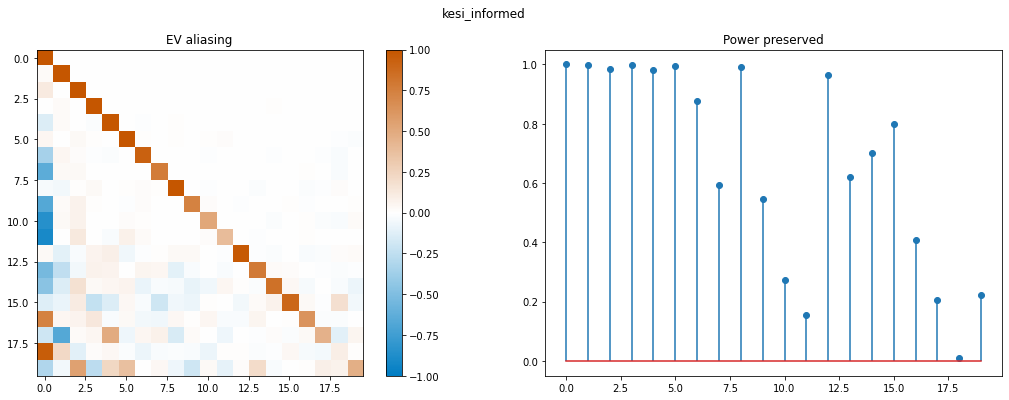

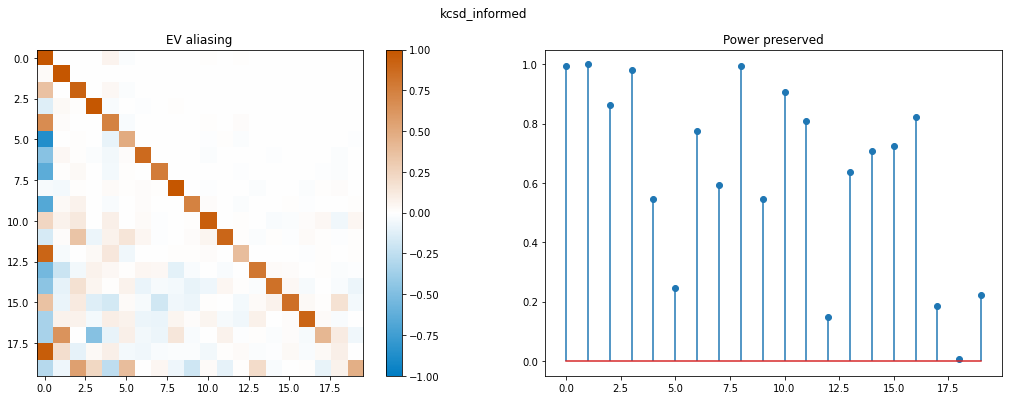

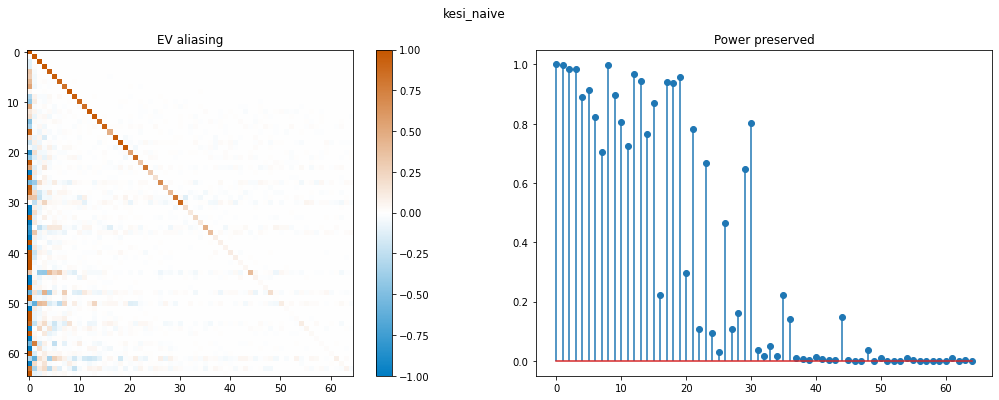

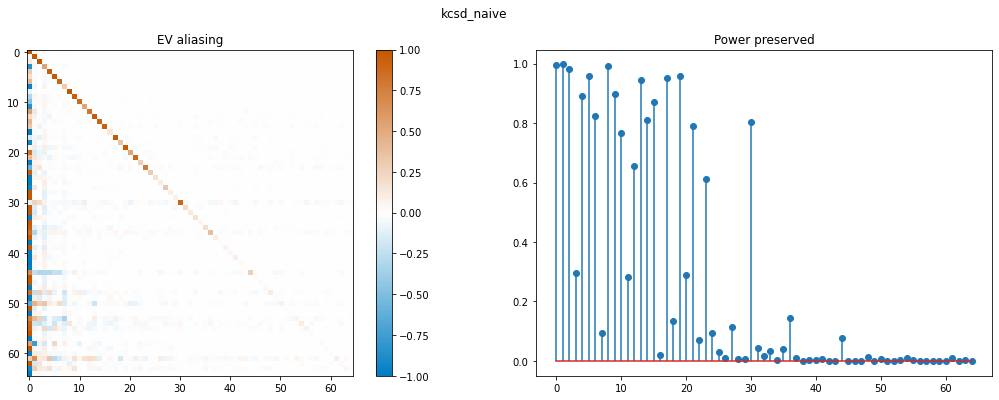

In [22]:
for name, EIGENVECTORS in eigenvectors.items():
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    IMAGES_NORM = IMAGES_OF_ES / np.sqrt(np.square(IMAGES_OF_ES).sum(axis=0)).reshape(1, -1)
    print(f'{name}\t{abs(np.square(IMAGES_NORM).sum(axis=0) - 1).max():.2e}')
    
    PROJECTION = np.matmul(IMAGES_NORM.T, EIGENVECTORS)
    plt.figure(figsize=(18, 6))
    plt.suptitle(name)

    plt.subplot(1, 2, 1)
    plt.title('EV aliasing')
    plt.imshow(PROJECTION, vmax=1, vmin=-1, cmap=cbf.bwr)
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title('Power preserved')
    plt.stem(np.square(np.diag(PROJECTION)))

(Obrazy w rzędach, wektory własne - w kolumnach)

Aliasing źródeł

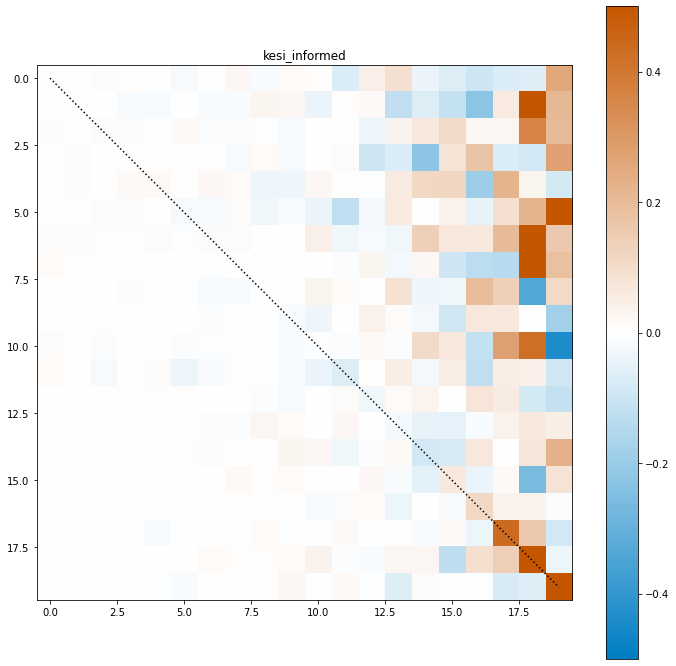

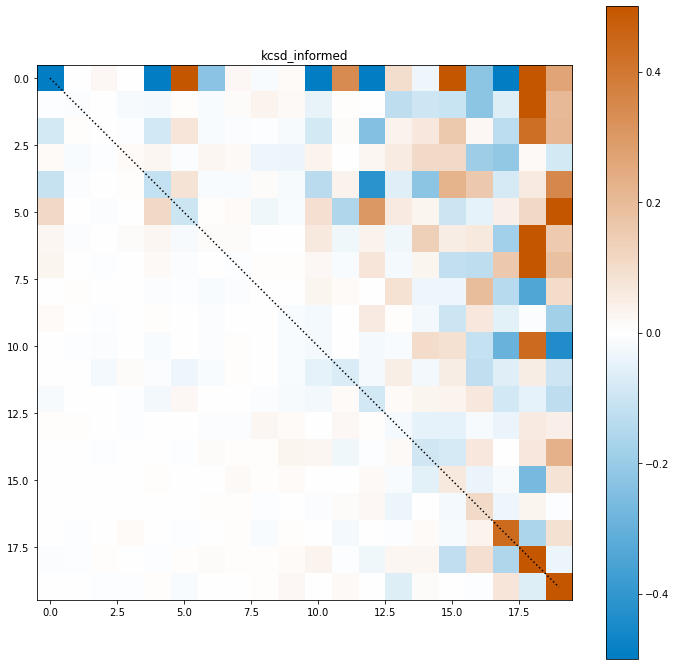

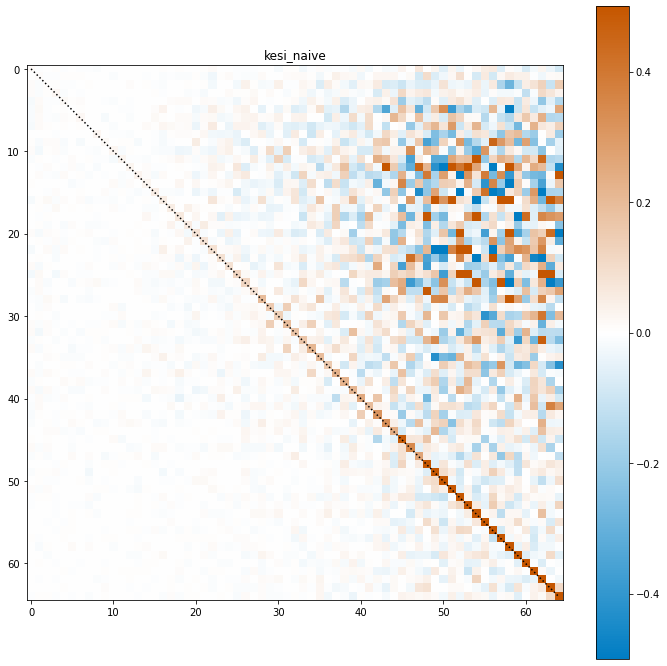

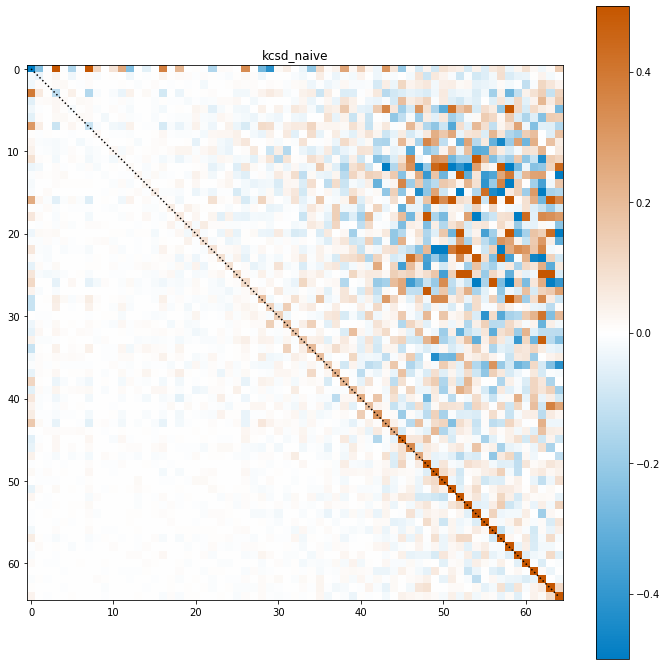

In [25]:
for name, images in images_of_eigensources.items():
    IMAGES_OF_ES = np.array([images[e.name]
                             for e in electrodes[name]])
    EIGENVECTORS = eigenvectors[name]
    EIGENVALUES = eigenvalues[name]
#     EXPECTED = np.matmul(EIGENVECTORS,
#                          np.diag(np.sqrt(EIGENVALUES)))
#     ERR = EXPECTED - IMAGES_OF_ES
#     ERR_EV = np.matmul(ERR.T, EIGENVECTORS)
    ERR_EV = np.diag(np.sqrt(EIGENVALUES)) - np.matmul(IMAGES_OF_ES.T, EIGENVECTORS)

    ALIASING = np.matmul(ERR_EV,
                         np.diag(1 / np.sqrt(EIGENVALUES)))
    amp = 0.5  # abs(ALIASING).max()

    plt.figure(figsize=(12, 12))
    plt.title(name)
    plt.imshow(ALIASING,
               vmax=amp,
               vmin=-amp,
               cmap=cbf.bwr)
    plt.plot([0, len(ALIASING) - 1],
             [0, len(ALIASING) - 1],
             ls=':',
             color=cbf.BLACK)
    plt.colorbar()

Normalizacja za pomocą pierwiastka z wartości własnej.

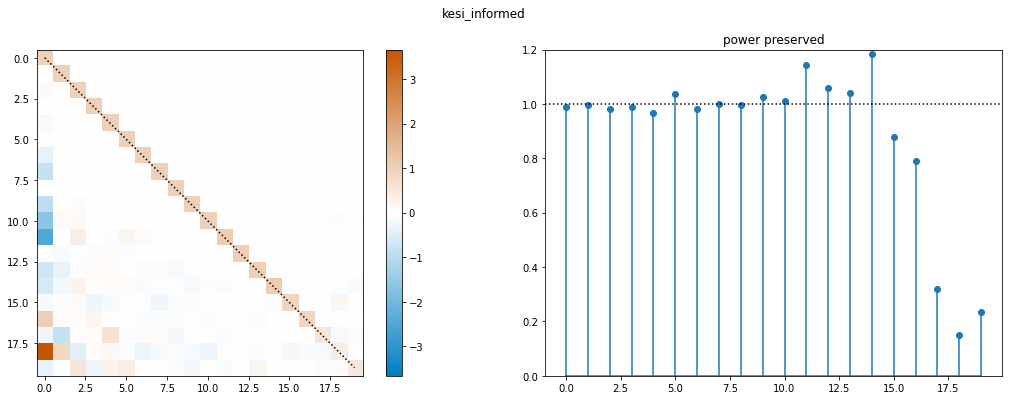

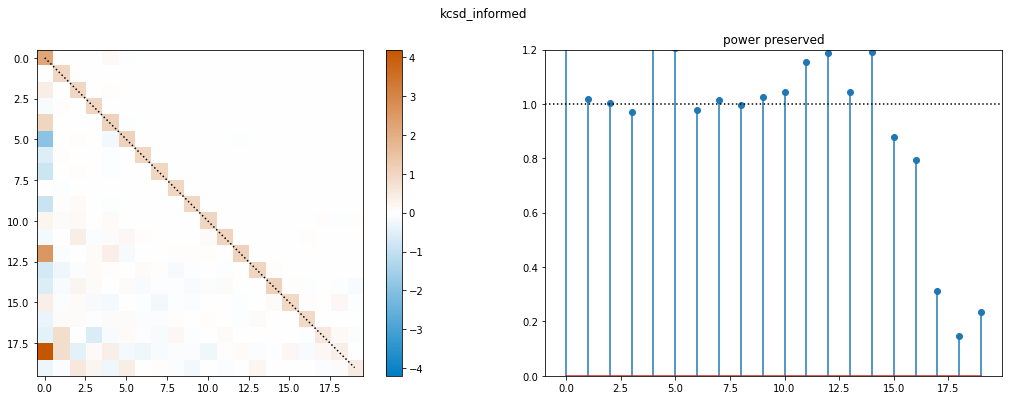

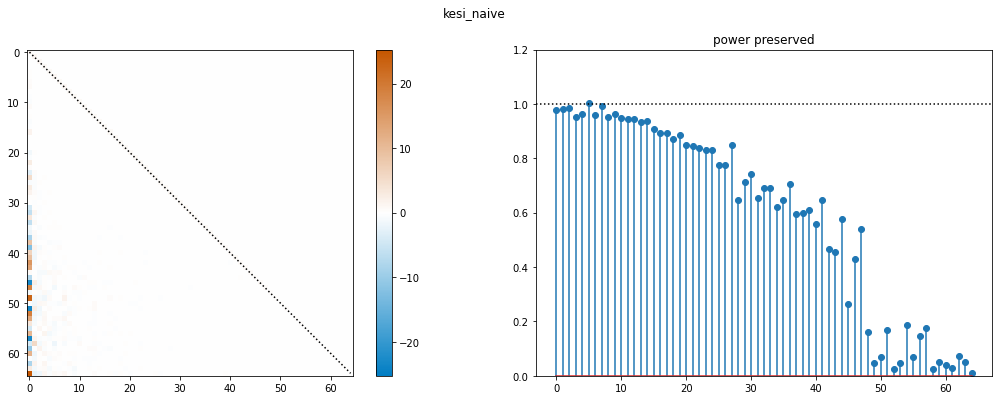

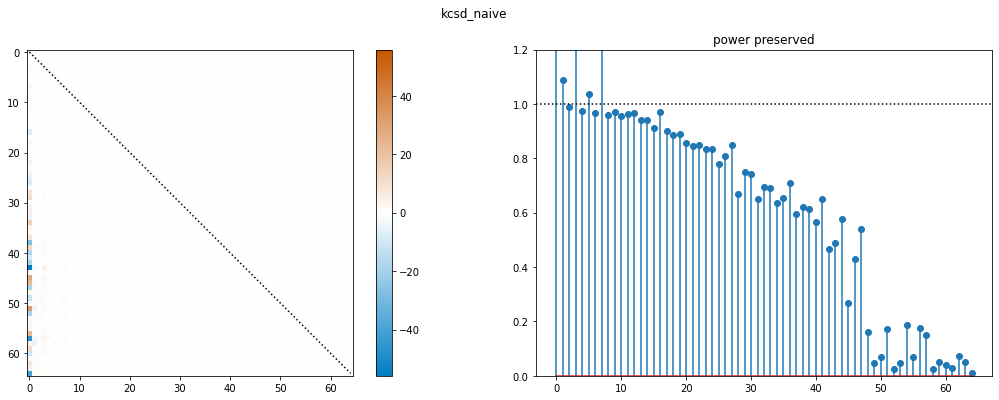

In [30]:
for name in eigenvectors:
    EIGENVECTORS = eigenvectors[name]
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    IMAGES_NORM = np.matmul(IMAGES_OF_ES,
                            np.diag(1./np.sqrt(eigenvalues[name])))
    MTX = np.matmul(IMAGES_NORM.T, EIGENVECTORS)
    amp = abs(MTX).max()
    
    plt.figure(figsize=(18, 6))
    plt.suptitle(name)
    
    plt.subplot(1, 2, 1)
    plt.imshow(MTX,
               vmax=amp,
               vmin=-amp,
               cmap=cbf.bwr)
    plt.plot([0, len(MTX) - 1],
             [0, len(MTX) - 1],
             ls=':',
             color=cbf.BLACK)
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title('power preserved')
    plt.stem(np.square(np.diag(MTX)))
    plt.axhline(1, ls=':', color=cbf.BLACK)
    plt.ylim(0, 1.2)

Sprawdzam (znormalizowane) błędy obrazów w porównaniu z obrazami teoretycznymi (przeskalowane wektory własne).

Chyba bez sensu. :)

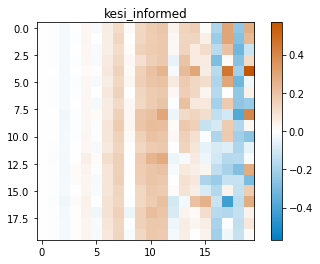

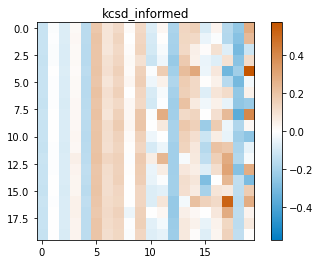

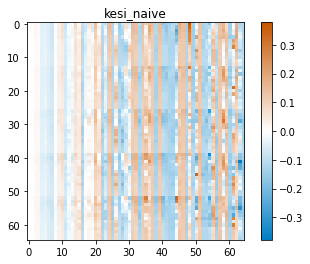

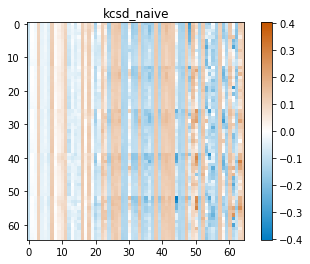

In [33]:
for name in eigenvectors:
    EIGENVECTORS = eigenvectors[name]
    EIGENVALUES = eigenvalues[name]
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    
#     IMAGES_NORM = np.matmul(IMAGES_OF_ES,
#                             np.diag(1./np.sqrt(eigenvalues[name])))
#     ERR_NORM = EIGENVECTORS - IMAGES_NORM

    ERR = np.matmul(EIGENVECTORS, np.diag(np.sqrt(EIGENVALUES))) - IMAGES_OF_ES
    ERR_NORM = ERR / np.sqrt(np.square(IMAGES_OF_ES).sum(axis=0)).reshape(1, -1)
    
    amp = abs(ERR_NORM).max()
    
    plt.figure()
    plt.title(name)
    plt.imshow(ERR_NORM, vmin=-amp, vmax=amp, cmap=cbf.bwr)
    plt.colorbar()

Porównanie źródeł własnych kCSD/kESI

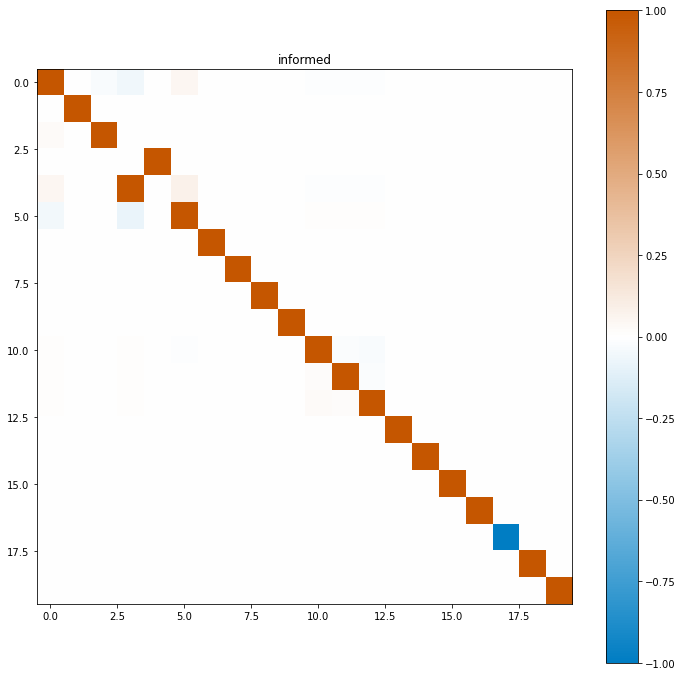

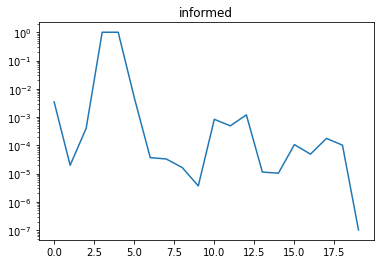

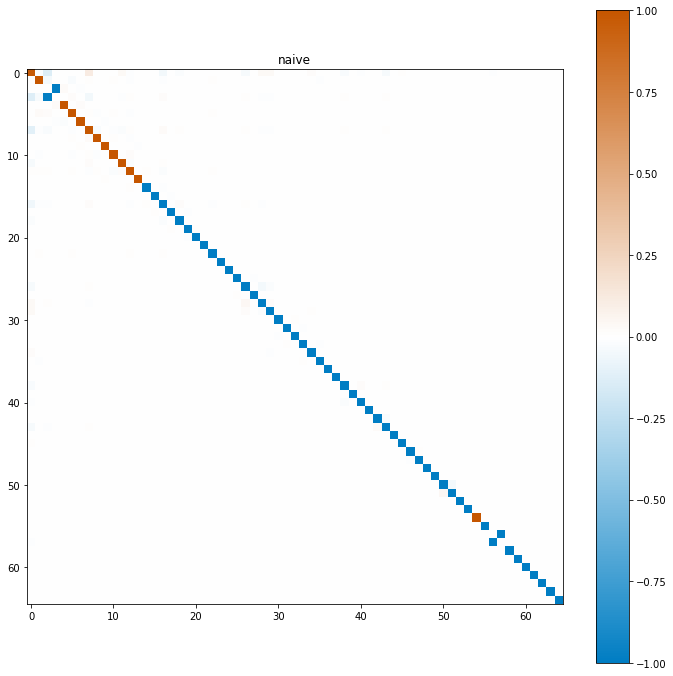

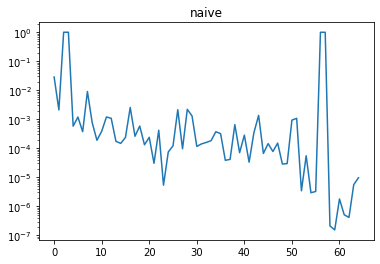

In [31]:
for setup in ['informed',
              'naive',
              ]:
    KCSD_KESI_ES = np.matmul(eigensources[f'kcsd_{setup}'].T,
                             eigensources[f'kesi_{setup}'])
    plt.figure(figsize=(12, 12))
    plt.title(setup)
    plt.imshow(KCSD_KESI_ES,
               cmap=cbf.bwr,
               vmin=-1,
               vmax=1)
    plt.colorbar()
    
    plt.figure()
    plt.title(setup)
    plt.plot(1 - np.diag(abs(KCSD_KESI_ES)))
    plt.yscale('log')

Porównanie wektorów własnych

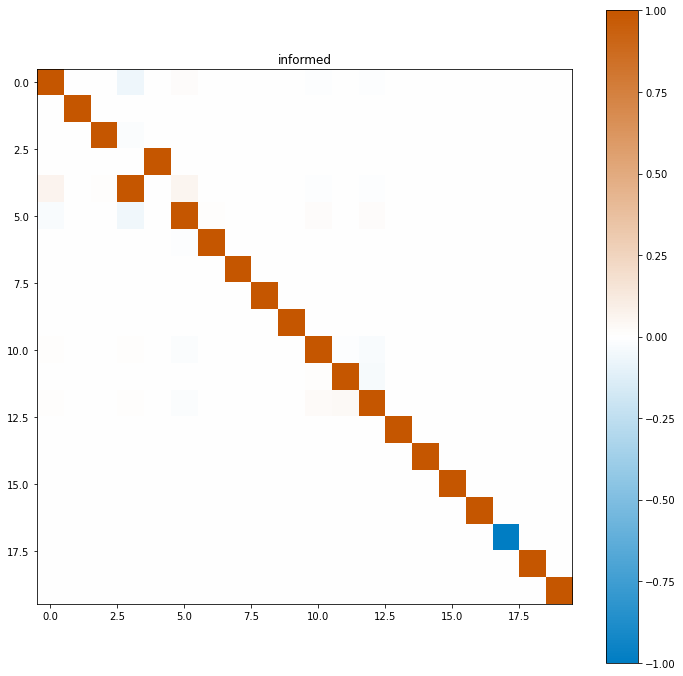

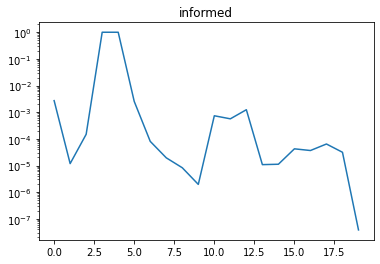

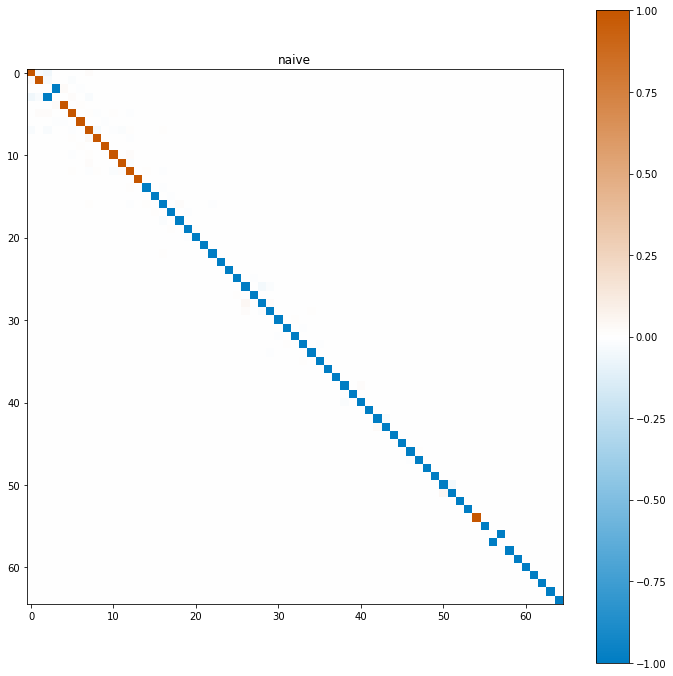

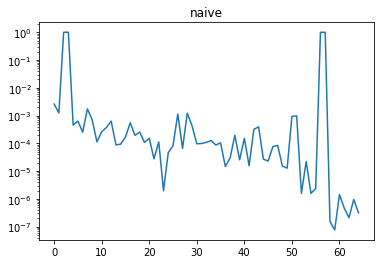

In [34]:
for setup in ['informed',
              'naive',
              ]:
    KCSD_KESI_EV = np.matmul(eigenvectors[f'kcsd_{setup}'].T,
                             eigenvectors[f'kesi_{setup}'])

    plt.figure(figsize=(12, 12))
    plt.title(setup)
    plt.imshow(KCSD_KESI_EV,
               cmap=cbf.bwr,
               vmin=-1,
               vmax=1)
    plt.colorbar()
    
    plt.figure()
    plt.title(setup)
    plt.plot(1 - np.diag(abs(KCSD_KESI_EV)))
    plt.yscale('log')

# Sprawdzenie odtwarzalności źródeł

In [35]:
import _fast_reciprocal_reconstructor as frr
import _common_new as common

In [36]:
# arc = np.arctan(abs(ELE.X / ELE.Z).max())
arc = np.arctan(E_X_DIST_MAX / INFORMED_R_MIN)
print(f'{arc / np.pi * 180} deg')

5.117399685701221 deg


In [37]:
def inflate(A):
    B = np.empty(2 * len(A) - 1)
    B[::2] = A
    B[1::2] = 0.5 * (A[:-1] + A[1:])
    return B

In [98]:
convolver = frr.ckESI_convolver([X,
                                 Y,
                                 Z],
                                [inflate(X),
#                                  np.array([0.]),
                                 inflate(Y),
                                 inflate(Z)])

In [99]:
conductivity = 0.33
# sd = convolver.ds('POT')[0] * 16 / 6
sd = SRC_R_MAX / 3
model_src = common.SphericalSplineSourceKCSD(0, 0, 0,
                                             [sd, 3 * sd],
                                             [[1],
                                              [0,
                                               2.25 / sd,
                                               -1.5 / sd ** 2,
                                               0.25 / sd ** 3]],
                                             conductivity)
print(3 * sd)

0.005625


In [100]:
SRC_R2 = (np.square(convolver.SRC_X)
          + np.square(convolver.SRC_Y)
          + np.square(convolver.SRC_Z))
SRC_IDX_NAIVE = ((SRC_R2 >= NAIVE_R_MIN ** 2)
                 & (SRC_R2 <= NAIVE_R_MAX ** 2)
                 & (abs(convolver.SRC_Y) < Y_DIST_MAX)
                 )

SRC_IDX_INFORMED = ((SRC_R2 >= INFORMED_R_MIN ** 2)
                    & (SRC_R2 <= INFORMED_R_MAX ** 2)
                    & (abs(convolver.SRC_Y) < Y_DIST_MAX)
                    & (((convolver.SRC_X * 0
                        + convolver.SRC_Y * 0
                        + convolver.SRC_Z
                        / np.sqrt(SRC_R2)) >= np.cos(arc)))
                   )
source_idx = {'naive': SRC_IDX_NAIVE,
              'informed': SRC_IDX_INFORMED}

In [101]:
CSD_R2 = (np.square(convolver.CSD_X)
          + np.square(convolver.CSD_Y)
          + np.square(convolver.CSD_Z))
CSD_IDX = CSD_R2 <= 0.090 ** 2

In [102]:
POT_R2 = (np.square(convolver.POT_X)
          + np.square(convolver.POT_Y)
          + np.square(convolver.POT_Z))
POT_ALLOWED = POT_R2 <= 0.090 ** 2

In [103]:
kernels = {f'{method}_{setup}': frr.ckESI_kernel_constructor(
                                   model_src,
                                   convolver,
                                   SRC_IDX,
                                   CSD_IDX,
                                   electrodes[f'{method}_{setup}'],
                                   weights=ROMBERG_N)
           for method in ['kcsd', 'kesi']
           for setup, SRC_IDX in source_idx.items()}

In [104]:
ks = kernels['kcsd_informed']
np.linalg.eigvalsh(ks.kernel)

array([1.42012335e-01, 1.80096798e-01, 2.16565740e-01, 3.15403444e-01,
       3.45030251e-01, 7.46556481e-01, 1.50338685e+00, 2.23719229e+00,
       4.43197214e+00, 9.09539509e+00, 1.03372272e+01, 4.17412228e+01,
       5.13641563e+01, 9.21177514e+01, 1.35025840e+02, 4.58732081e+02,
       4.90655904e+02, 1.84563882e+03, 3.22558682e+03, 3.90731145e+04])

In [105]:
regularization_parameters = np.logspace(-3, 6, 37)

In [106]:
import kesi
import kesi._verbose as verbose

Test na wektorach własnych

In [107]:
ns = {name: len(ks._pre_kernel)
      for name, ks in kernels.items()}
reconstructors = {name: verbose.VerboseFFR._CrossKernelReconstructor(
                            kesi._engine._LinearKernelSolver(
                                ks.kernel),
                            np.matmul(np.diag(np.sqrt(eigenvalues[name])
                                              / ns[name]),
                                      eigenvectors[name].T))
                  for name, ks in kernels.items()}

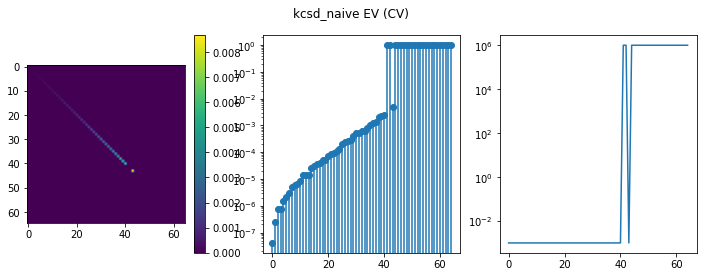

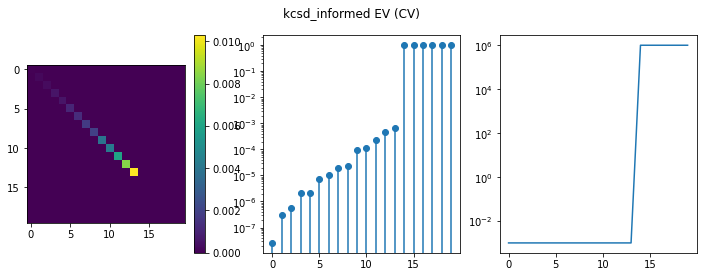

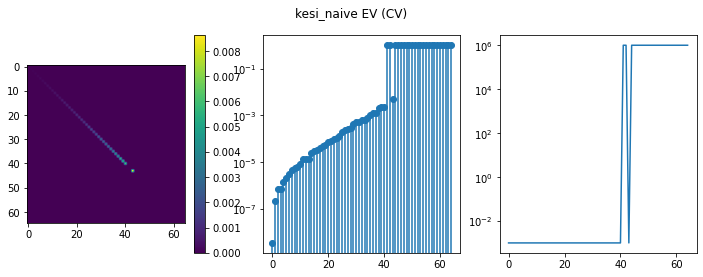

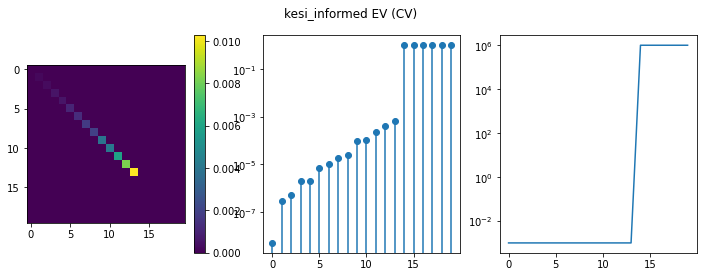

In [111]:
for name, reconstructor in reconstructors.items():
    rps = []
    reconstruction = []
    
    for i, POTENTIAL in enumerate(eigenvectors[name].T):
        POTENTIAL = POTENTIAL.copy()
    #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
    #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
        errors = common.cv(reconstructor, POTENTIAL, regularization_parameters)
        regularization_parameter = regularization_parameters[np.argmin(errors)]
        rps.append(regularization_parameter)
        reconstruction.append(
            reconstructor(POTENTIAL,
                          regularization_parameter=regularization_parameter))
        
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{name} EV (CV)')
    
    plt.subplot(1, 3, 1)
    plt.imshow(reconstruction)
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.stem(abs(1 - np.diag(reconstruction)
                     * np.sqrt(eigenvalues[name])))
    plt.yscale('log')

    plt.subplot(1, 3, 3)
    plt.plot(rps)
    plt.yscale('log')

Optymalny dobór regularyzacji

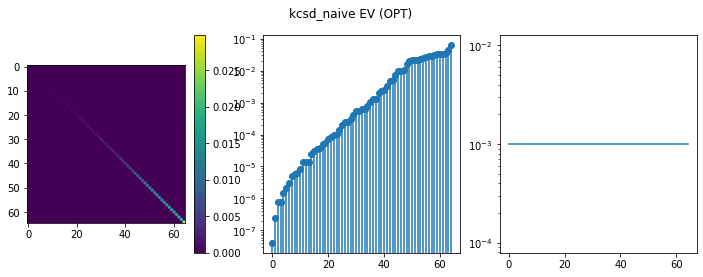

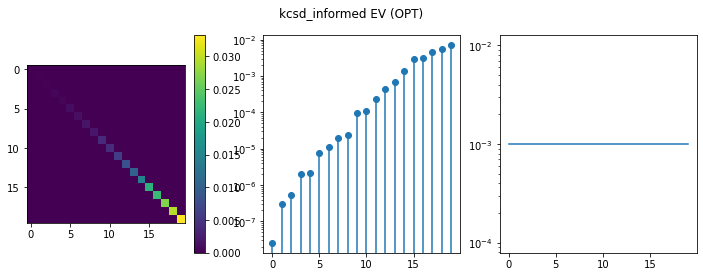

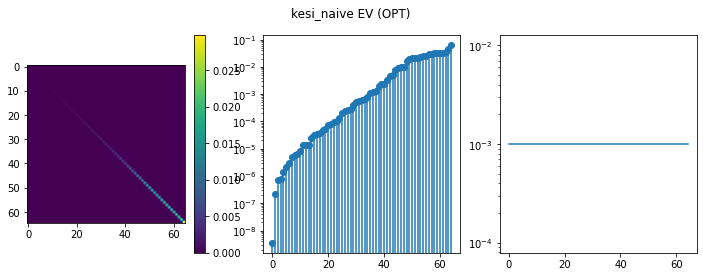

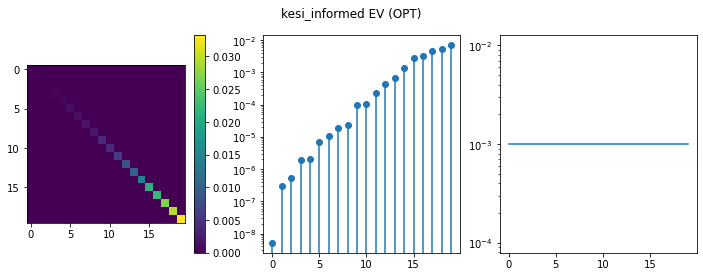

In [112]:
for name, reconstructor in reconstructors.items():
    rps = []
    reconstruction = []
    
    for i, POTENTIAL in enumerate(eigenvectors[name].T):
        POTENTIAL = POTENTIAL.copy()
    #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
    #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
        errors = [abs(reconstructor(POTENTIAL, regularization_parameter=r)[i] - 1)
                  for r in regularization_parameters]
        regularization_parameter = regularization_parameters[np.argmin(errors)]
        rps.append(regularization_parameter)
        reconstruction.append(
            reconstructor(POTENTIAL,
                          regularization_parameter=regularization_parameter))
        
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{name} EV (OPT)')
    
    plt.subplot(1, 3, 1)
    plt.imshow(reconstruction)
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.stem(abs(1 - np.diag(reconstruction)
                     * np.sqrt(eigenvalues[name])))
    plt.yscale('log')

    plt.subplot(1, 3, 3)
    plt.plot(rps)
    plt.yscale('log')

Odtworzenie źródeł własnych z ich obrazów

`POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())` to normalizacja przez pierwiastek wartości własnej modelu idealnego.

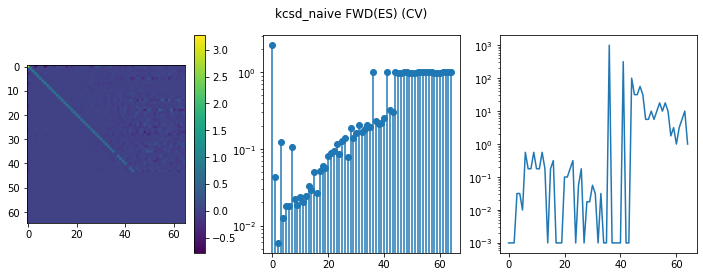

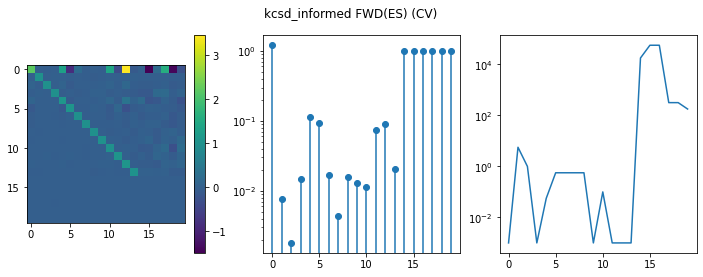

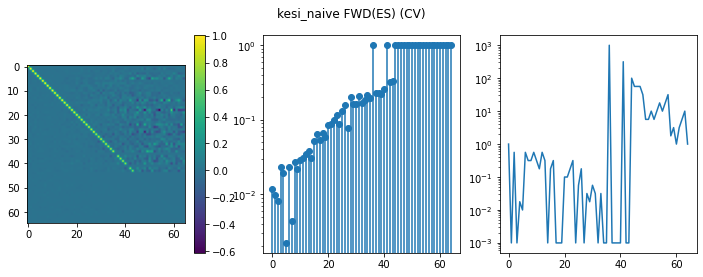

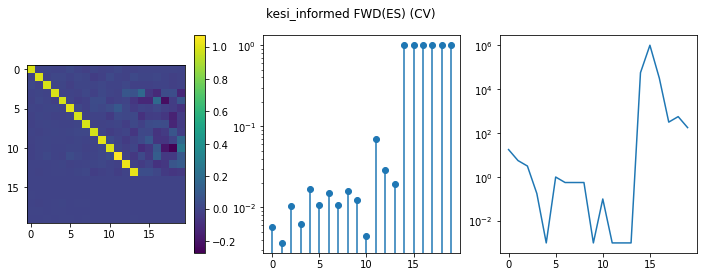

In [123]:
for name, reconstructor in reconstructors.items():

    rps = []
    reconstruction = []
    
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    
    for i, POTENTIAL in enumerate(IMAGES_OF_ES.T):
        POTENTIAL = POTENTIAL.copy()
    #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
    #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
        errors = common.cv(reconstructor, POTENTIAL, regularization_parameters)
        regularization_parameter = regularization_parameters[np.argmin(errors)]
        rps.append(regularization_parameter)
        reconstruction.append(
            reconstructor(POTENTIAL,
                          regularization_parameter=regularization_parameter))
        
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{name} FWD(ES) (CV)')
    
    plt.subplot(1, 3, 1)
    plt.imshow(reconstruction)
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.stem(abs(1 - np.diag(reconstruction)))
    plt.yscale('log')

    plt.subplot(1, 3, 3)
    plt.plot(rps)
    plt.yscale('log')

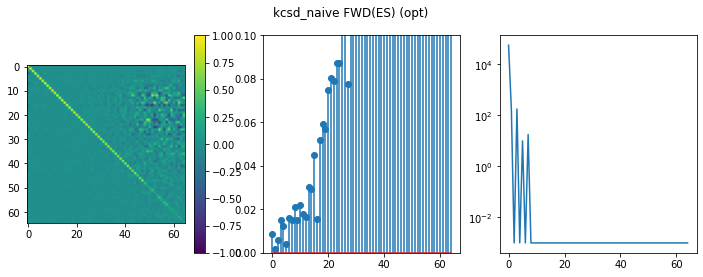

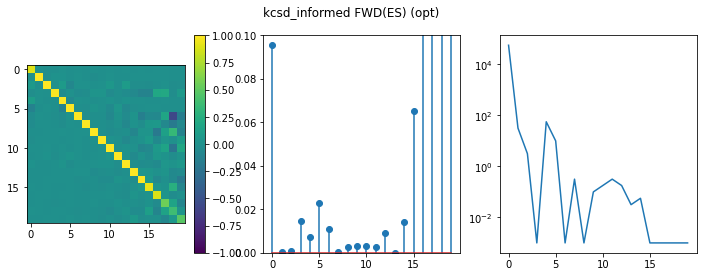

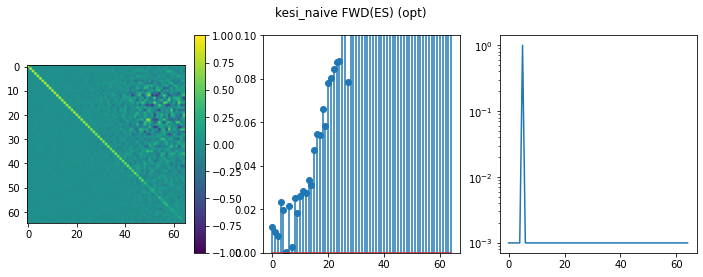

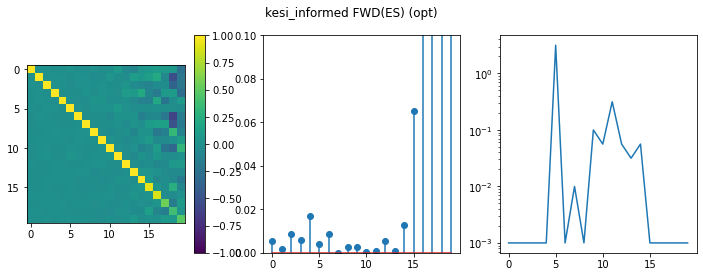

In [114]:
for name, reconstructor in reconstructors.items():

    rps = []
    reconstruction = []
    
    IMAGES_OF_ES = np.array([images_of_eigensources[name][e.name]
                             for e in electrodes[name]])
    
    for i, POTENTIAL in enumerate(IMAGES_OF_ES.T):
        POTENTIAL = POTENTIAL.copy()
    #     POTENTIAL /= np.sqrt(np.square(POTENTIAL).sum())
    #     POTENTIAL *= np.sqrt(eigenvalues['kcsd_informed'][i])
        errors = [abs(reconstructor(POTENTIAL, regularization_parameter=r)[i] - 1)
                  for r in regularization_parameters]
        regularization_parameter = regularization_parameters[np.argmin(errors)]
        rps.append(regularization_parameter)
        reconstruction.append(
            reconstructor(POTENTIAL,
                          regularization_parameter=regularization_parameter))
        
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{name} FWD(ES) (opt)')
    
    plt.subplot(1, 3, 1)
    plt.imshow(reconstruction, vmin=-1, vmax=1)
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.stem(abs(1 - np.diag(reconstruction)))
    plt.ylim(0, 0.1)
#     plt.yscale('log')

    plt.subplot(1, 3, 3)
    plt.plot(rps)
    plt.yscale('log')

# test rekonstruktorów

In [115]:
reconstructors_csd = {name: verbose.VerboseFFR._CrossKernelReconstructor(
                                kesi._engine._LinearKernelSolver(
                                    ks.kernel),
                                ks.cross_kernel)
                      for name, ks in kernels.items()}

In [116]:
def wrap_csd(DATA):
    WRAPPED = np.zeros(convolver.shape('CSD'))
    WRAPPED[CSD_IDX] = DATA
    return WRAPPED

In [117]:
def rmse(A, B):
    return np.sqrt(np.square(A - B).mean())

In [ ]:
RECONSTRUCTOR_STATS = []

name = 'kcsd_informed'

for i in range(len(eigenvalues[name])):
    with np.load(f'{ES_PREFIX}_{name}_ES{i:02d}.npz') as fh:
        XYZ = [fh[c] for c in 'XYZ']
        CSD = fh['CSD']  # [:, XYZ[1] == 0, :]
        
    amp = abs(CSD).max()
    row = {'CSD_AMP': amp,
           'ES': i,
           }
    
    for rec_name, rec in reconstructors_csd.items():
        POTENTIAL = np.array([images_of_eigensources[name][e.name][i]
                              for e in electrodes[rec_name]])

        row[f'RMSE_{rec_name}_0'] = rmse(CSD, wrap_csd(rec(POTENTIAL))) / amp
        
        errors = common.cv(rec, POTENTIAL, regularization_parameters)
        regularization_parameter = regularization_parameters[np.argmin(errors)]
        row[f'RMSE_{rec_name}_CV'] = rmse(CSD, wrap_csd(rec(POTENTIAL,
                          regularization_parameter=regularization_parameter))) / amp
        row[f'RP_{rec_name}_OPT'] = regularization_parameter

        errors = [rmse(CSD, wrap_csd(rec(POTENTIAL, regularization_parameter=r)))
                  for r in regularization_parameters]
        regularization_parameter = regularization_parameters[np.argmin(errors)]
        row[f'RMSE_{rec_name}_OPT'] = rmse(CSD, wrap_csd(rec(POTENTIAL,
                          regularization_parameter=regularization_parameter))) / amp
        row[f'RP_{rec_name}_OPT'] = regularization_parameter
        
    RECONSTRUCTOR_STATS.append(row)
    
RECONSTRUCTOR_STATS = pd.DataFrame(RECONSTRUCTOR_STATS)

In [ ]:
RECONSTRUCTOR_STATS

In [ ]:
plt.title('No regularization')
for name in reconstructors_csd:
    plt.plot(RECONSTRUCTOR_STATS.ES,
             RECONSTRUCTOR_STATS[f'RMSE_{name}_0'],
             label=name)

plt.legend(loc='best')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.ylabel(f'RMSE [{amp:.2e}]')

In [ ]:
plt.title('CV')
for name in reconstructors_csd:
    plt.plot(RECONSTRUCTOR_STATS.ES,
             RECONSTRUCTOR_STATS[f'RMSE_{name}_CV'],
             label=name)

plt.legend(loc='best')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.ylabel(f'RMSE [{amp:.2e}]')

In [ ]:
plt.title('OPT')
for name in reconstructors_csd:
    plt.plot(RECONSTRUCTOR_STATS.ES,
             RECONSTRUCTOR_STATS[f'RMSE_{name}_OPT'],
             label=name)

plt.legend(loc='best')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.ylabel(f'RMSE [{amp:.2e}]')